In [3]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from sklearn.utils.extmath import randomized_svd as fast_svd
from sklearn.decomposition import PCA
from hyperspy import signals

C:\Users\Chenyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [121]:
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
raw_data = sio.loadmat(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

## Case1: generate k-space subset from consective k points
This is the same as what I did for the cropped data that was used to test different methods.

(114, 114, 50, 50)


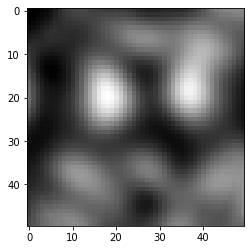

In [122]:
halfsize = 25
truth_data = truth_data.reshape([114,114,128,128])
center = int(truth_data.shape[-1]/2)
truth_data = truth_data[:,:,center-halfsize:center+halfsize,center-halfsize:center+halfsize]
print(truth_data.shape)
# np.save(path + 'DenoiseInput_cropped/SiDislocation/Simulation_truth_SiDisl_slice5_1000FPS_crpped_'\
#         +str(halfsize*2*halfsize*2)+'layers.npy',truth_data)
plt.imshow(truth_data[10,10,:,:])

In [123]:
# reshape the 3D tensor into 2D matrix
temp = raw_data.reshape([114,114,128,128])
temp = temp[:,:,center-halfsize:center+halfsize,center-halfsize:center+halfsize]
print(temp.shape)
# np.save(path + 'DenoiseInput_cropped/SiDislocation/Simulation_noisy_SiDisl_slice5_1000FPS_crpped_'\
#         +str(halfsize*2*halfsize*2)+'layers.npy',temp)
raw_data_2D = np.reshape(temp,(temp.shape[0]*temp.shape[1],temp.shape[2]*temp.shape[3]))
im = signals.Signal2D(raw_data_2D.astype('float'))
im = im.transpose(signal_axes = 1)
im

(114, 114, 50, 50)


<Signal1D, title: , dimensions: (12996|2500)>

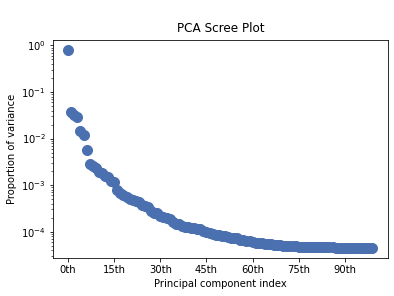

In [124]:
im.decomposition()
im.plot_explained_variance_ratio(n=100,linewidth=1)

In [126]:
var = np.asarray(im.get_explained_variance_ratio())
print(np.sum(var[0:54]))

0.944429812297541


(12996, 2500)
(114, 114, 2500)
33.3470153819788


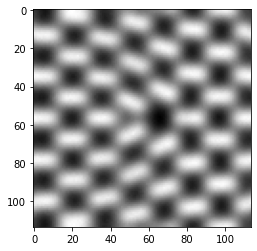

In [125]:
im_denoise = im.get_decomposition_model(55)
denoised_data = np.asarray(im_denoise)
print(denoised_data.shape)
denoised_data = denoised_data.reshape([114,114,halfsize*2*halfsize*2])
truth_data = truth_data.reshape([114,114,halfsize*2*halfsize*2])
print(denoised_data.shape)
plt.imshow(np.sum(denoised_data,axis=2))
print(averagePSNR(denoised_data, truth_data,0))

(114, 114, 400)
30.30082004912522


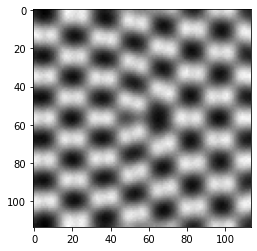

In [12]:
denoised_data = denoised_data.reshape([114,114,halfsize*2*halfsize*2])
truth_data = truth_data.reshape([114,114,halfsize*2*halfsize*2])
print(denoised_data.shape)
plt.imshow(np.sum(denoised_data,axis=2))
print(averagePSNR(denoised_data, truth_data,0))

## Case2: downsampling k space uniformly

In [85]:
path ='/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/'
raw_data = sio.loadmat(path + 'Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

In [86]:
factor = 6
truth_data = truth_data.reshape([114,114,128,128])
truth_data = truth_data[:,:,0:-1:factor,0:-1:factor]
truth_data = truth_data.reshape([114,114,truth_data.shape[2]*truth_data.shape[3]])
print(truth_data.shape)

(114, 114, 484)


In [87]:
# reshape the 3D tensor into 2D matrix
temp = raw_data.reshape([114,114,128,128])
temp = temp[:,:,0:-1:factor,0:-1:factor]
print(temp.shape)
raw_data_2D = np.reshape(temp,(temp.shape[0]*temp.shape[1],temp.shape[2]*temp.shape[3]))
im = signals.Signal2D(raw_data_2D.astype('float'))
im = im.transpose(signal_axes = 1)
im

(114, 114, 22, 22)


<Signal1D, title: , dimensions: (12996|484)>

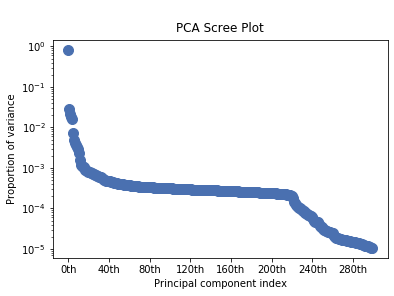

In [88]:
im.decomposition()
im.plot_explained_variance_ratio(n=300,linewidth=1)

(12996, 484)
(114, 114, 484)
26.90770861298421


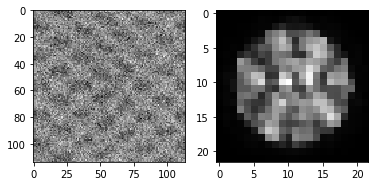

In [96]:
im_denoise = im.get_decomposition_model(60)
denoised_data = np.asarray(im_denoise)
print(denoised_data.shape)
denoised_data = denoised_data.reshape([114,114,denoised_data.shape[1]])
print(denoised_data.shape)
print(averagePSNR(denoised_data, truth_data,0))
plt.subplot(121)
plt.imshow(np.sum(denoised_data,axis=2))
plt.subplot(122)
side = int(np.sqrt(denoised_data.shape[2]))
plt.imshow(denoised_data[10,10,:].reshape(side,side))

In [60]:
denoised_data.shape

(114, 114, 4096)

In [10]:
# transpose_option = 1 for tensor denoised data, where first dimension is for rec space and need to be transposed to match simulation
# transpose_option = 0 for noisy data, third dimension is for rec space and no need to transpose
def averagePSNR(denoised_data,truth_data,transpose_option):
    nlayer = truth_data.shape[2]
    side = np.sqrt(nlayer)
    side = int(side)
    psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
    for irow in range(truth_data.shape[0]):
        for icol in range(truth_data.shape[1]):
            truth = truth_data[irow,icol,:].reshape(side,side)
            if transpose_option == 1:
                denoise = np.transpose(denoised_data[:,irow,icol].reshape(side,side))
            else:
                denoise = denoised_data[irow,icol,:].reshape(side,side)
            psnr_map[irow,icol] = psnr(truth,denoise)
    return np.mean(psnr_map)

In [11]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))